# Ali NN

## Imports and Cuda Device

In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter


%matplotlib inline     
sns.set(color_codes=True)

import gc

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")

## KAN Class

In [3]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Data Import

In [4]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [31]:
mcf7_smartS_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
mcf7_smartS_filn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_smartS_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
hcc_smartS_filn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
mcf7_dropS_filn = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
hcc_dropS_filn = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [32]:
mcf7_smartS_filn, mcf7_smartS_filn_norm_idx = process_df_smartseq(mcf7_smartS_filn.copy(), mcf7_smartS_meta, "MCF7_")
hcc_smartS_filn, hcc_smartS_filn_norm_idx = process_df_smartseq(hcc_smartS_filn.copy(), hcc_smartS_meta, "HCC1806_")
mcf7_dropS_filn, mcf7_dropS_filn_norm_idx = process_df_dropseq(mcf7_dropS_filn, "MCF7_")
hcc_dropS_filn, hcc_dropS_filn_norm_idx = process_df_dropseq(hcc_dropS_filn, "HCC1806_")

In [33]:
mcf7_smartS_filn["mcf"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["mcf"] = np.zeros_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["mcf"] = np.ones_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["mcf"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

mcf7_smartS_filn["smart"] = np.ones_like(mcf7_smartS_filn.iloc[:, 0])
hcc_smartS_filn["smart"] = np.ones_like(hcc_smartS_filn.iloc[:, 0])
mcf7_dropS_filn["smart"] = np.zeros_like(mcf7_dropS_filn.iloc[:, 0])
hcc_dropS_filn["smart"] = np.zeros_like(hcc_dropS_filn.iloc[:, 0])

dataset_list = [mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn]
dataset_names = ["MCF7_SmartSeq", "HCC1806_SmartSeq", "MCF7_DropSeq", "HCC1806_DropSeq"]
datasets = dict(zip(dataset_names, dataset_list))
norm_idx_datasets = dict(zip(dataset_names, [mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx]))

In [8]:
dropS_norm_idx = np.concatenate([mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])
smartS_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx])

smartS_idx = np.concatenate([mcf7_smartS_filn.index, hcc_smartS_filn.index])

mcf7_idx = np.concatenate([mcf7_smartS_filn.index, mcf7_dropS_filn.index])

merged_norm_idx = np.concatenate([mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx])

## Train-Test Split

In [9]:
datasets_train = {}
datasets_test = {}

for name, dataset in datasets.items():
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset.index.isin(norm_idx_datasets[name]))
    datasets_train[name] = train_dataset
    datasets_test[name] = test_dataset

merged_train_dataset = pd.concat(datasets_train.values()).fillna(0).astype(np.int32)
merged_test_dataset = pd.concat(datasets_test.values()).fillna(0).astype(np.int32)

## Free Up Memory #1

In [10]:
# Free up memory
del dataset_list, dataset_names, datasets, norm_idx_datasets, mcf7_smartS_filn, hcc_smartS_filn, mcf7_dropS_filn, hcc_dropS_filn, mcf7_smartS_filn_norm_idx, hcc_smartS_filn_norm_idx, mcf7_dropS_filn_norm_idx, hcc_dropS_filn_norm_idx

In [11]:
gc.collect()
torch.cuda.empty_cache()

## Define Neural Networks

In [12]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

In [13]:
class NNBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNBig, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [14]:
class NNMedium(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNMedium, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_size, H1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [15]:
class KANBig(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANBig, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [16]:
class KANSmall(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(KANSmall, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [17]:
class KANTiny(nn.Module):
    def __init__(self, in_size, H1):
        super(KANTiny, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            KANLinear(H1, 1))

    def forward(self, x):
        return self.layers(x)

## Model Measuring

In [18]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)

In [28]:
@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.show()

## Initialize Datasets

In [20]:
data_loaders_train = {}
data_loaders_test = {}

for name in datasets_train.keys():
    data_loaders_train[name] = DataLoader(NNDataset(datasets_train[name], merged_norm_idx), batch_size=64, shuffle=True)
    data_loaders_test[name] = DataLoader(NNDataset(datasets_test[name], merged_norm_idx), batch_size=32)

merged_data_loader_train = DataLoader(NNDataset(merged_train_dataset, merged_norm_idx), batch_size=128, shuffle=True)
merged_data_loader_test = DataLoader(NNDataset(merged_test_dataset, merged_norm_idx), batch_size=64)

## Training Helpers

In [21]:
def train(model, train_config, writer=None):
    total_epochs = 0
    for config_type, config in train_config:
        if config_type == 0:
            iter_count, subtrain_config = config
            for _ in range(iter_count):
                total_epochs += train(model, subtrain_config, writer)
        elif config_type == 1:
            num_epochs, data_loader, test_loader, optimizer, criterion = config
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs[:, 0], labels)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                    optimizer.step()
                    running_loss += loss.item()

                writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
                measure_model_log(writer, model, test_loader, total_epochs)
                writer.flush()
                total_epochs += 1
        else:
            raise Exception("Invalid training config")
    return total_epochs
        

In [22]:
#lr_sgd = 1e-2
#lr_ada = 1e-2
#lr_admw = 1e-3
#wd_admw = 1e-4

# Define the optimizer
#sgd = optim.SGD(model.parameters(), lr=lr_sgd)
#adm = optim.Adam(model.parameters(), lr=lr_adm)
#ada = optim.Adagrad(model.parameters(), lr=lr_ada)
#admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

## Training Neural Networks

### Training Over Individual Datasets

In [23]:
input_size = 3002

#### Traditional Neural Networks

In [42]:
models = {}
for name in data_loaders_test.keys():
    model = NNMedium(input_size, 4096, 1024, 512).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 44553.30687522888


  2%|▏         | 1/50 [00:00<00:12,  3.87it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 50.0%
Epoch 2, Loss: 2509.7960319519043


  4%|▍         | 2/50 [00:00<00:12,  3.86it/s]

F1 Score: 0.3333333333333333
Recall: 0.2
Accuracy on test: 60.0%
Epoch 3, Loss: 220.49323450028896


  6%|▌         | 3/50 [00:00<00:12,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 39.8558304659673


  8%|▊         | 4/50 [00:01<00:11,  3.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:01<00:11,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 6.041943556167706e-41


 12%|█▏        | 6/50 [00:01<00:11,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:01<00:11,  3.86it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 1.8245717637579655e-37


 16%|█▌        | 8/50 [00:02<00:10,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 6.62897566891624e-20


 18%|█▊        | 9/50 [00:02<00:10,  3.87it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 2.0623753101000698e-29


 20%|██        | 10/50 [00:02<00:10,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 11, Loss: 2.3921019578087866e-39


 22%|██▏       | 11/50 [00:02<00:09,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:09,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:03<00:09,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:03<00:09,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:03<00:08,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:08,  3.89it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:08,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:04<00:07,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 1.4134324970780222e-16


 40%|████      | 20/50 [00:05<00:07,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:07,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:05<00:07,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 46%|████▌     | 23/50 [00:06<00:10,  2.47it/s]

Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:09,  2.79it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 2.8593495164547892e-42


 50%|█████     | 25/50 [00:06<00:08,  3.02it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:07<00:07,  3.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0


 54%|█████▍    | 27/50 [00:07<00:06,  3.46it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:06,  3.61it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:07<00:05,  3.73it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:05,  3.82it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  3.87it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:08<00:04,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:09<00:04,  3.92it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 1.185811358720899e-19


 72%|███████▏  | 36/50 [00:09<00:03,  3.90it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  3.93it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:10<00:03,  3.94it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:10<00:02,  3.95it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 3.0635761559439524e-38


 80%|████████  | 40/50 [00:10<00:02,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 37.74399319291115


 82%|████████▏ | 41/50 [00:10<00:02,  3.89it/s]

F1 Score: 0.9795918367346939
Recall: 0.96
Accuracy on test: 98.0%
Epoch 42, Loss: 5.989957123994827


 84%|████████▍ | 42/50 [00:11<00:02,  3.88it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  3.84it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 6.866362475191604e-44


 88%|████████▊ | 44/50 [00:11<00:01,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  3.88it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:12<00:01,  3.91it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 94%|█████████▍| 47/50 [00:12<00:01,  2.91it/s]

Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:13<00:00,  3.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:13<00:00,  3.30it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 1.6385739218439966e-33


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 123878.989180247


  2%|▏         | 1/50 [00:00<00:11,  4.28it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 2, Loss: 8363.786295572916


  4%|▍         | 2/50 [00:00<00:11,  4.30it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 3, Loss: 2462.6246287027993


  6%|▌         | 3/50 [00:00<00:10,  4.32it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 4, Loss: 333.75682703653973


  8%|▊         | 4/50 [00:00<00:10,  4.31it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 5, Loss: 149.08938344319662


 10%|█         | 5/50 [00:01<00:10,  4.33it/s]

F1 Score: 0.3225806451612903
Recall: 0.25
Accuracy on test: 43.24324324324324%
Epoch 6, Loss: 25.360286076863606


 12%|█▏        | 6/50 [00:01<00:10,  4.17it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 7, Loss: 611.1656227111816


 14%|█▍        | 7/50 [00:01<00:10,  4.16it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 8, Loss: 68.8963254292806


 16%|█▌        | 8/50 [00:01<00:09,  4.21it/s]

F1 Score: 0.5161290322580645
Recall: 0.4
Accuracy on test: 59.45945945945946%
Epoch 9, Loss: 6.556369781494141


 18%|█▊        | 9/50 [00:02<00:09,  4.22it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 10, Loss: 9.16432778040568


 20%|██        | 10/50 [00:02<00:09,  4.21it/s]

F1 Score: 0.08333333333333333
Recall: 0.05
Accuracy on test: 40.54054054054054%
Epoch 11, Loss: 7.0627031326293945


 22%|██▏       | 11/50 [00:02<00:09,  4.21it/s]

F1 Score: 0.7017543859649122
Recall: 1.0
Accuracy on test: 54.054054054054056%
Epoch 12, Loss: 6.036436915397644


 24%|██▍       | 12/50 [00:02<00:08,  4.23it/s]

F1 Score: 0.6
Recall: 0.45
Accuracy on test: 67.56756756756756%
Epoch 13, Loss: 2.097317894299825


 26%|██▌       | 13/50 [00:03<00:08,  4.28it/s]

F1 Score: 0.7547169811320755
Recall: 1.0
Accuracy on test: 64.86486486486487%
Epoch 14, Loss: 0.9445938042675456
F1 Score: 0.7407407407407407
Recall: 1.0
Accuracy on test: 62.16216216216216%


 28%|██▊       | 14/50 [00:03<00:08,  4.12it/s]

Epoch 15, Loss: 8.73828891913096


 30%|███       | 15/50 [00:03<00:08,  4.14it/s]

F1 Score: 0.8837209302325582
Recall: 0.95
Accuracy on test: 86.48648648648648%
Epoch 16, Loss: 0.8750425477822622


 32%|███▏      | 16/50 [00:03<00:08,  4.23it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.5906875741978487


 34%|███▍      | 17/50 [00:04<00:07,  4.24it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 18, Loss: 1.1553761462370555


 36%|███▌      | 18/50 [00:04<00:07,  4.28it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.0232246388716586


 38%|███▊      | 19/50 [00:04<00:07,  4.29it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.006991433576852539


 40%|████      | 20/50 [00:04<00:06,  4.29it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.07974245102514033


 42%|████▏     | 21/50 [00:04<00:06,  4.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.5686700225704998


 44%|████▍     | 22/50 [00:05<00:06,  4.23it/s]

F1 Score: 0.9473684210526315
Recall: 0.9
Accuracy on test: 94.5945945945946%
Epoch 23, Loss: 0.0020990222692679173


 46%|████▌     | 23/50 [00:05<00:06,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 24, Loss: 0.7064098492264796


 48%|████▊     | 24/50 [00:05<00:06,  4.24it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 25, Loss: 0.00011314079623699531


 50%|█████     | 25/50 [00:05<00:05,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 5.802105638798988e-06


 52%|█████▏    | 26/50 [00:06<00:05,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 7.178369045475937e-08
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 54%|█████▍    | 27/50 [00:06<00:07,  2.90it/s]

Epoch 28, Loss: 8.388743316580394e-09


 56%|█████▌    | 28/50 [00:06<00:06,  3.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 1.4618445309767455e-07


 58%|█████▊    | 29/50 [00:07<00:05,  3.51it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 4.912718797814478e-08


 60%|██████    | 30/50 [00:07<00:05,  3.64it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 1.4103386073810555e-07


 62%|██████▏   | 31/50 [00:07<00:04,  3.82it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 3.9712104347999766e-08


 64%|██████▍   | 32/50 [00:07<00:04,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.005041995231461025


 66%|██████▌   | 33/50 [00:08<00:04,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 4.9544068213283345e-11


 68%|██████▊   | 34/50 [00:08<00:03,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 1.0633205020568375e-09


 70%|███████   | 35/50 [00:08<00:03,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 9.650435145623488e-09


 72%|███████▏  | 36/50 [00:08<00:03,  4.25it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 1.0762266345246143e-13


 74%|███████▍  | 37/50 [00:09<00:03,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 5.649294889584183e-15


 76%|███████▌  | 38/50 [00:09<00:02,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 2.7500158539188437e-08


 78%|███████▊  | 39/50 [00:09<00:02,  4.26it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 6.173253574992946e-10


 80%|████████  | 40/50 [00:09<00:02,  4.28it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 4.642043713131219e-06


 82%|████████▏ | 41/50 [00:09<00:02,  4.31it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 1.5737239725438943e-15


 84%|████████▍ | 42/50 [00:10<00:01,  4.33it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 6.057848199007305e-08


 86%|████████▌ | 43/50 [00:10<00:01,  4.33it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 1.6963603447086872e-19


 88%|████████▊ | 44/50 [00:10<00:01,  4.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 2.0432381454089585e-11


 90%|█████████ | 45/50 [00:10<00:01,  4.31it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 3.4240445579913193e-14


 92%|█████████▏| 46/50 [00:11<00:00,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 4.069586871730724e-14


 94%|█████████▍| 47/50 [00:11<00:00,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 48, Loss: 1.6235860914351474e-10


 96%|█████████▌| 48/50 [00:11<00:00,  4.24it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 9.974616350883514e-15


 98%|█████████▊| 49/50 [00:11<00:00,  4.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 1.126789560241296e-07


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2686003151746438


 33%|███▎      | 1/3 [00:07<00:15,  7.64s/it]

F1 Score: 0.9721749006246451
Recall: 0.9661399548532731
Accuracy on test: 97.73462783171522%
Epoch 2, Loss: 0.06064278924552255


 67%|██████▋   | 2/3 [00:15<00:07,  7.66s/it]

F1 Score: 0.9730649277005954
Recall: 0.9683972911963883
Accuracy on test: 97.80397595931576%
Epoch 3, Loss: 0.04091564301462913


100%|██████████| 3/3 [00:22<00:00,  7.63s/it]

F1 Score: 0.9746764209341587
Recall: 0.9774266365688488
Accuracy on test: 97.91955617198336%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5318866722569193


 33%|███▎      | 1/3 [00:05<00:10,  5.09s/it]

F1 Score: 0.9596486412297557
Recall: 0.9853438556933484
Accuracy on test: 94.99489274770173%
Epoch 2, Loss: 0.08124516825900292


 67%|██████▋   | 2/3 [00:10<00:05,  5.08s/it]

F1 Score: 0.9698863636363636
Recall: 0.9622322435174746
Accuracy on test: 96.39087504256042%
Epoch 3, Loss: 0.04346329366584858


100%|██████████| 3/3 [00:15<00:00,  5.06s/it]

F1 Score: 0.9622804491793838
Recall: 0.9419391206313416
Accuracy on test: 95.53966632618318%


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


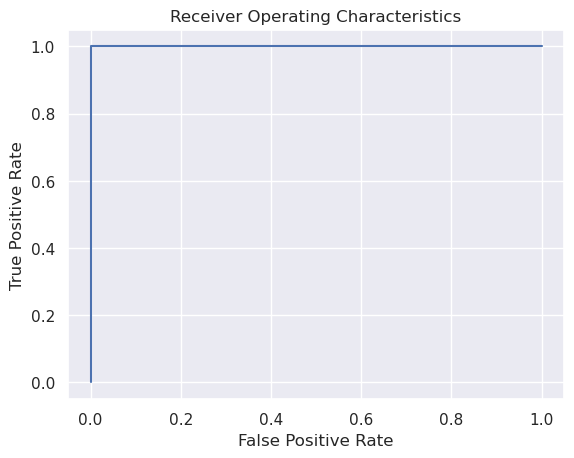

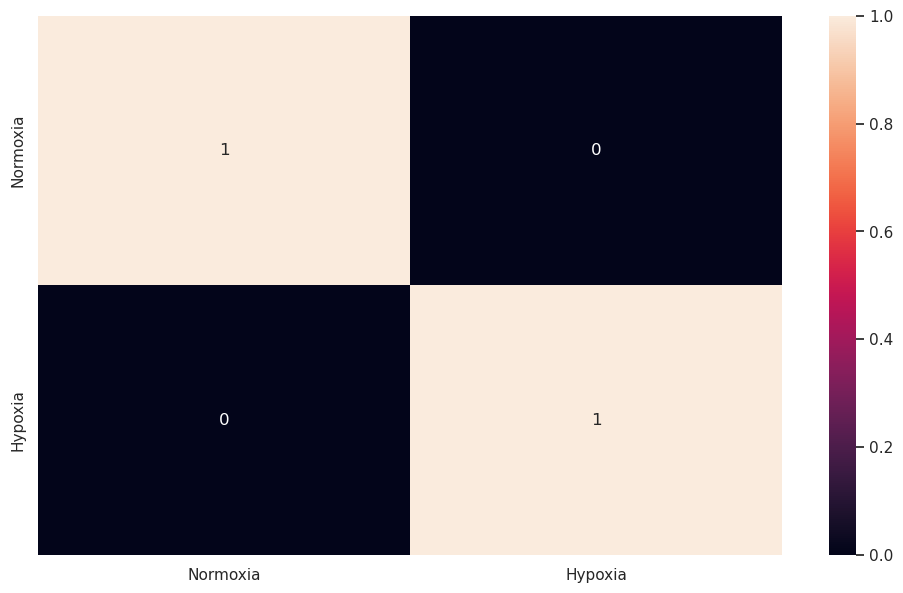

HCC1806_SmartSeq
F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%


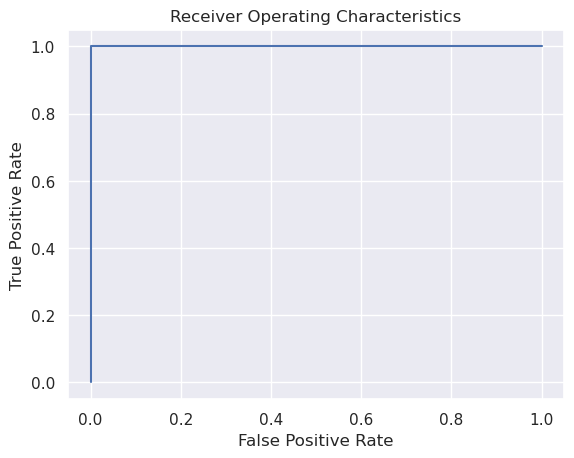

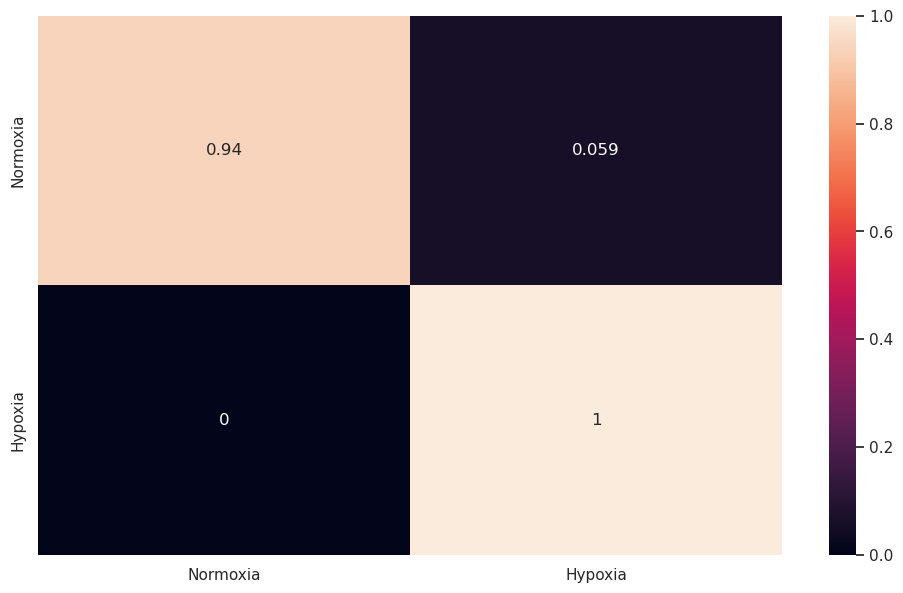

MCF7_DropSeq
F1 Score: 0.9743878412609063
Recall: 0.9768623024830699
Accuracy on test: 97.89644012944983%


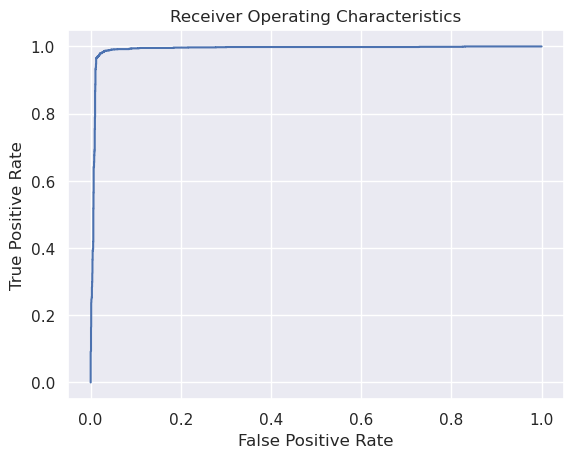

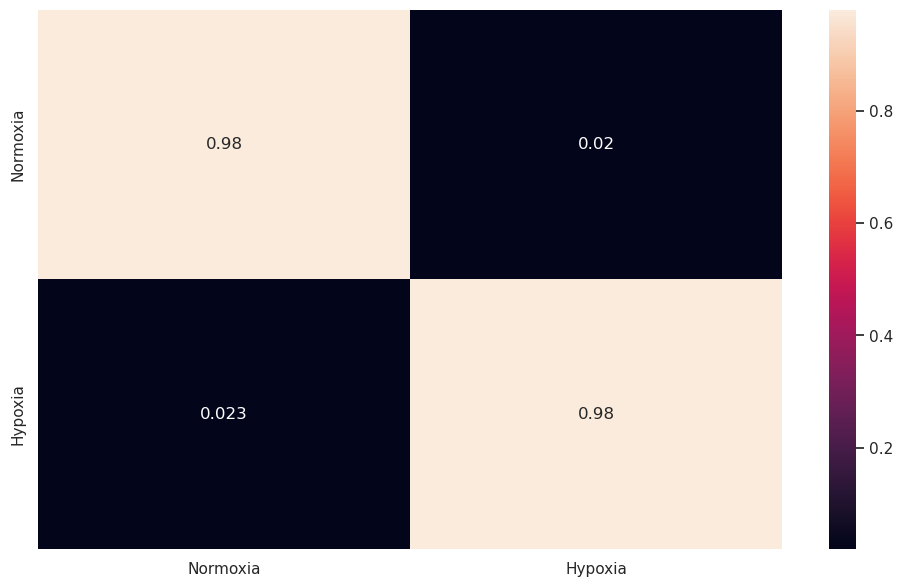

HCC1806_DropSeq
F1 Score: 0.9613163972286374
Recall: 0.9385569334836528
Accuracy on test: 95.43752128021791%


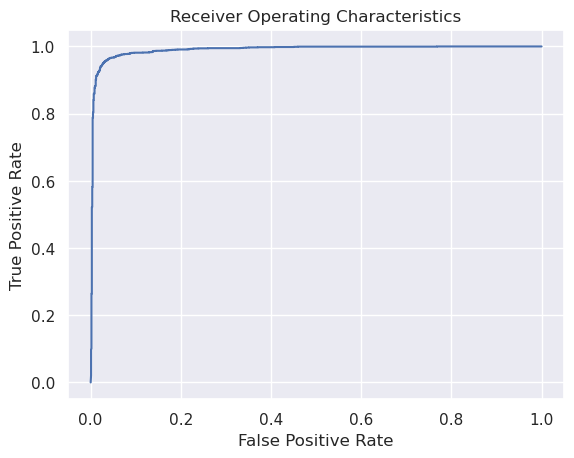

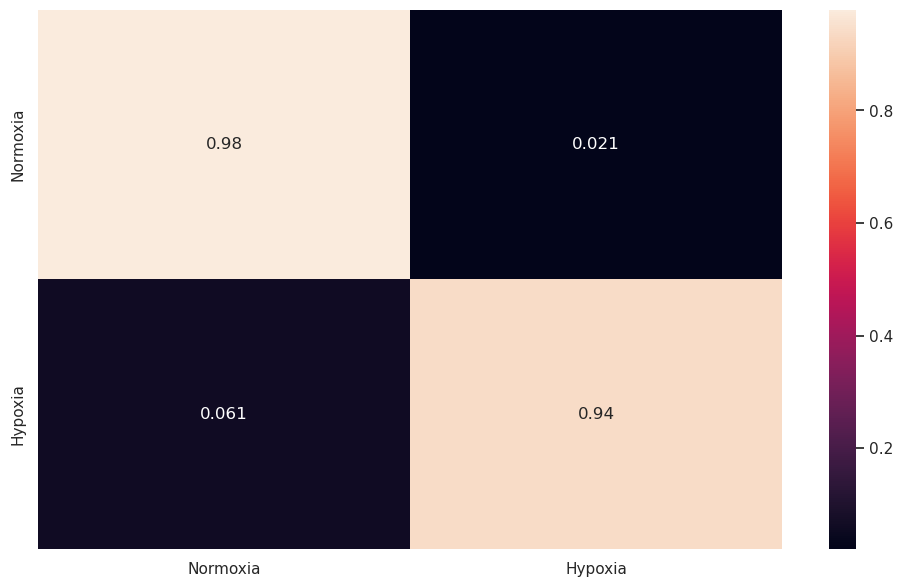

In [43]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [45]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

NameError: name 'models' is not defined

#### KAN (Kolmogorov Arnold Networks)

In [47]:
models = {}
for name in data_loaders_test.keys():
    model = KANTiny(input_size, 64).to(device)
    writer = SummaryWriter()
    bcelogits = nn.BCEWithLogitsLoss()

    lr_ada = 1e-2
    ada = optim.Adagrad(model.parameters(), lr=lr_ada)
    train_config = [
        [1, [50 if "Smart" in name else 3, data_loaders_train[name], data_loaders_test[name], ada, bcelogits]],
    ]
    train(model, train_config, writer)
    models[name] = model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 967.668360710144


  2%|▏         | 1/50 [00:00<00:12,  3.81it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 50.0%
Epoch 2, Loss: 100.73484802246094


  4%|▍         | 2/50 [00:00<00:11,  4.04it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 3, Loss: 0.0


  6%|▌         | 3/50 [00:00<00:11,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 4, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


  8%|▊         | 4/50 [00:01<00:27,  1.69it/s]

Epoch 5, Loss: 0.0


 10%|█         | 5/50 [00:02<00:20,  2.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 6, Loss: 0.0


 12%|█▏        | 6/50 [00:02<00:16,  2.60it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 7, Loss: 0.0


 14%|█▍        | 7/50 [00:02<00:14,  2.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 8, Loss: 0.0


 16%|█▌        | 8/50 [00:02<00:12,  3.29it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 0.0


 18%|█▊        | 9/50 [00:03<00:11,  3.53it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 10, Loss: 0.0


 20%|██        | 10/50 [00:03<00:10,  3.74it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 11, Loss: 0.0


 22%|██▏       | 11/50 [00:03<00:10,  3.76it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:03<00:09,  3.89it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:04<00:09,  3.85it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:04<00:09,  3.97it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:04<00:08,  4.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:04<00:08,  4.07it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:04<00:08,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:05<00:07,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:05<00:07,  4.14it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:05<00:07,  4.05it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:05<00:07,  4.13it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:06<00:06,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 23, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 46%|████▌     | 23/50 [00:06<00:08,  3.25it/s]

Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:06<00:07,  3.49it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:07<00:06,  3.66it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:07<00:06,  3.83it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 27, Loss: 0.0


 54%|█████▍    | 27/50 [00:07<00:05,  3.96it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:07<00:05,  3.98it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:08<00:05,  4.03it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:08<00:04,  4.09it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:08<00:04,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:08<00:04,  4.06it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:09<00:04,  4.11it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:09<00:03,  4.16it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:09<00:03,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:09<00:03,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:09<00:03,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:10<00:02,  4.22it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:10<00:02,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:10<00:02,  4.23it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:10<00:02,  4.12it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:11<00:01,  4.15it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:11<00:01,  4.17it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:11<00:01,  4.18it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:11<00:01,  4.20it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:12<00:00,  4.19it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 47, Loss: 0.0
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


 94%|█████████▍| 47/50 [00:12<00:00,  3.04it/s]

Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:12<00:00,  3.32it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:13<00:00,  3.47it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 50, Loss: 0.0


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Loss: 940.3256098429362


  2%|▏         | 1/50 [00:00<00:11,  4.29it/s]

F1 Score: 0.0
Recall: 0.0
Accuracy on test: 45.94594594594595%
Epoch 2, Loss: 378.36898549397785


  4%|▍         | 2/50 [00:00<00:10,  4.37it/s]

F1 Score: 0.7272727272727273
Recall: 1.0
Accuracy on test: 59.45945945945946%
Epoch 3, Loss: 178.56961059570312


  6%|▌         | 3/50 [00:00<00:10,  4.45it/s]

F1 Score: 0.75
Recall: 0.6
Accuracy on test: 78.37837837837837%
Epoch 4, Loss: 28.24608834584554


  8%|▊         | 4/50 [00:00<00:10,  4.44it/s]

F1 Score: 0.975609756097561
Recall: 1.0
Accuracy on test: 97.2972972972973%
Epoch 5, Loss: 20.52269999186198


 10%|█         | 5/50 [00:01<00:10,  4.46it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 6, Loss: 0.20061399539311728


 12%|█▏        | 6/50 [00:01<00:09,  4.50it/s]

F1 Score: 0.8571428571428571
Recall: 0.75
Accuracy on test: 86.48648648648648%
Epoch 7, Loss: 7.038148244222005


 14%|█▍        | 7/50 [00:01<00:09,  4.31it/s]

F1 Score: 0.9523809523809523
Recall: 1.0
Accuracy on test: 94.5945945945946%
Epoch 8, Loss: 7.413398106892903


 16%|█▌        | 8/50 [00:01<00:09,  4.39it/s]

F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%
Epoch 9, Loss: 9.565552157660326


 18%|█▊        | 9/50 [00:02<00:09,  4.36it/s]

F1 Score: 0.926829268292683
Recall: 0.95
Accuracy on test: 91.8918918918919%
Epoch 10, Loss: 0.03268931061029434


 20%|██        | 10/50 [00:02<00:09,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 11, Loss: 0.0


 22%|██▏       | 11/50 [00:02<00:08,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 12, Loss: 0.0


 24%|██▍       | 12/50 [00:02<00:08,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 13, Loss: 0.0


 26%|██▌       | 13/50 [00:02<00:08,  4.46it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 14, Loss: 0.0


 28%|██▊       | 14/50 [00:03<00:08,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 15, Loss: 0.0


 30%|███       | 15/50 [00:03<00:07,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 16, Loss: 0.0


 32%|███▏      | 16/50 [00:03<00:07,  4.47it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 17, Loss: 0.0


 34%|███▍      | 17/50 [00:03<00:07,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 18, Loss: 0.0


 36%|███▌      | 18/50 [00:04<00:07,  4.55it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 19, Loss: 0.0


 38%|███▊      | 19/50 [00:04<00:06,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 20, Loss: 0.0


 40%|████      | 20/50 [00:04<00:06,  4.52it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 21, Loss: 0.0


 42%|████▏     | 21/50 [00:04<00:06,  4.52it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 22, Loss: 0.0


 44%|████▍     | 22/50 [00:04<00:06,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 23, Loss: 0.0


 46%|████▌     | 23/50 [00:05<00:05,  4.51it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 24, Loss: 0.0


 48%|████▊     | 24/50 [00:05<00:05,  4.38it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 25, Loss: 0.0


 50%|█████     | 25/50 [00:05<00:05,  4.44it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 26, Loss: 0.0


 52%|█████▏    | 26/50 [00:05<00:05,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 27, Loss: 0.0
F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%


 54%|█████▍    | 27/50 [00:06<00:07,  2.94it/s]

Epoch 28, Loss: 0.0


 56%|█████▌    | 28/50 [00:06<00:06,  3.29it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 29, Loss: 0.0


 58%|█████▊    | 29/50 [00:06<00:05,  3.59it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 30, Loss: 0.0


 60%|██████    | 30/50 [00:07<00:05,  3.82it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 31, Loss: 0.0


 62%|██████▏   | 31/50 [00:07<00:04,  4.00it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 32, Loss: 0.0


 64%|██████▍   | 32/50 [00:07<00:04,  4.09it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 33, Loss: 0.0


 66%|██████▌   | 33/50 [00:07<00:04,  4.06it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 34, Loss: 0.0


 68%|██████▊   | 34/50 [00:08<00:03,  4.14it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 35, Loss: 0.0


 70%|███████   | 35/50 [00:08<00:03,  4.24it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 36, Loss: 0.0


 72%|███████▏  | 36/50 [00:08<00:03,  4.32it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 37, Loss: 0.0


 74%|███████▍  | 37/50 [00:08<00:02,  4.36it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 38, Loss: 0.0


 76%|███████▌  | 38/50 [00:08<00:02,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 39, Loss: 0.0


 78%|███████▊  | 39/50 [00:09<00:02,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 40, Loss: 0.0


 80%|████████  | 40/50 [00:09<00:02,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 41, Loss: 0.0


 82%|████████▏ | 41/50 [00:09<00:02,  4.49it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 42, Loss: 0.0


 84%|████████▍ | 42/50 [00:09<00:01,  4.41it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 43, Loss: 0.0


 86%|████████▌ | 43/50 [00:10<00:01,  4.39it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 44, Loss: 0.0


 88%|████████▊ | 44/50 [00:10<00:01,  4.44it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 45, Loss: 0.0


 90%|█████████ | 45/50 [00:10<00:01,  4.45it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 46, Loss: 0.0


 92%|█████████▏| 46/50 [00:10<00:00,  4.46it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 47, Loss: 0.0


 94%|█████████▍| 47/50 [00:10<00:00,  4.50it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 48, Loss: 0.0


 96%|█████████▌| 48/50 [00:11<00:00,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 49, Loss: 0.0


 98%|█████████▊| 49/50 [00:11<00:00,  4.53it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%
Epoch 50, Loss: 0.0


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]

F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.09788897042970321


 33%|███▎      | 1/3 [00:06<00:13,  6.72s/it]

F1 Score: 0.9774901519414744
Recall: 0.9802483069977427
Accuracy on test: 98.15071659731855%
Epoch 2, Loss: 0.05035903853900401


 67%|██████▋   | 2/3 [00:13<00:06,  6.68s/it]

F1 Score: 0.9780405405405406
Recall: 0.9802483069977427
Accuracy on test: 98.19694868238558%
Epoch 3, Loss: 0.038766059195846185


100%|██████████| 3/3 [00:20<00:00,  6.67s/it]

F1 Score: 0.9764271513774496
Recall: 0.9700902934537246
Accuracy on test: 98.08136846971799%



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1697286427648657


 33%|███▎      | 1/3 [00:04<00:08,  4.40s/it]

F1 Score: 0.9720159908623643
Recall: 0.9594137542277339
Accuracy on test: 96.66326183180117%
Epoch 2, Loss: 0.07940738805083801


 67%|██████▋   | 2/3 [00:08<00:04,  4.38s/it]

F1 Score: 0.9723252496433666
Recall: 0.9605411499436303
Accuracy on test: 96.69731018045626%
Epoch 3, Loss: 0.05954990296310786


100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

F1 Score: 0.9746764209341587
Recall: 0.9763246899661782
Accuracy on test: 96.93564862104188%


MCF7_SmartSeq
F1 Score: 1.0
Recall: 1.0
Accuracy on test: 100.0%


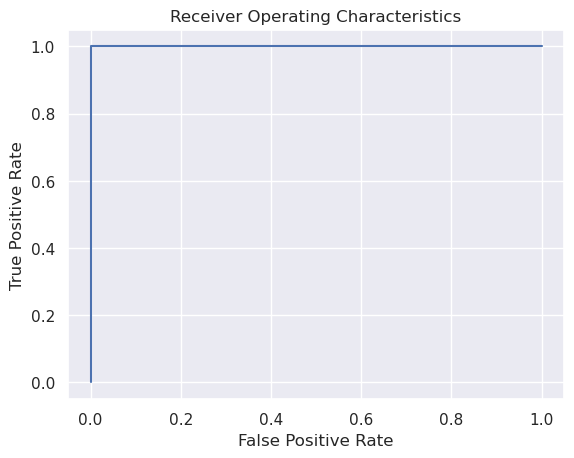

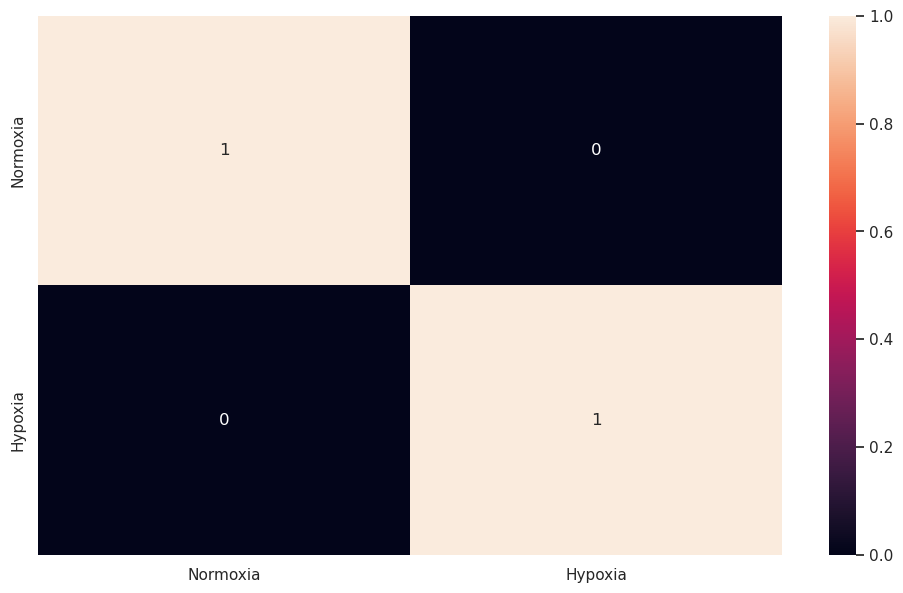

HCC1806_SmartSeq
F1 Score: 0.9743589743589743
Recall: 0.95
Accuracy on test: 97.2972972972973%


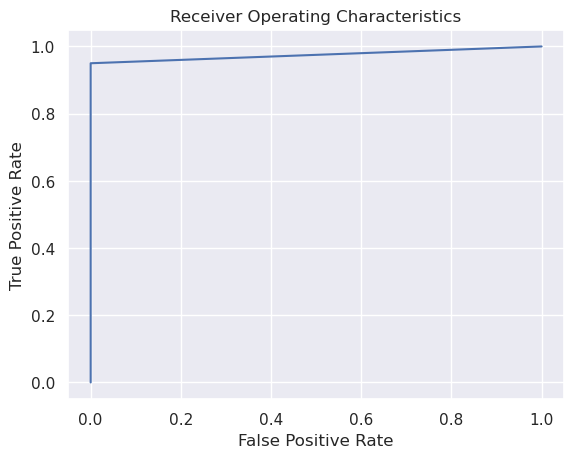

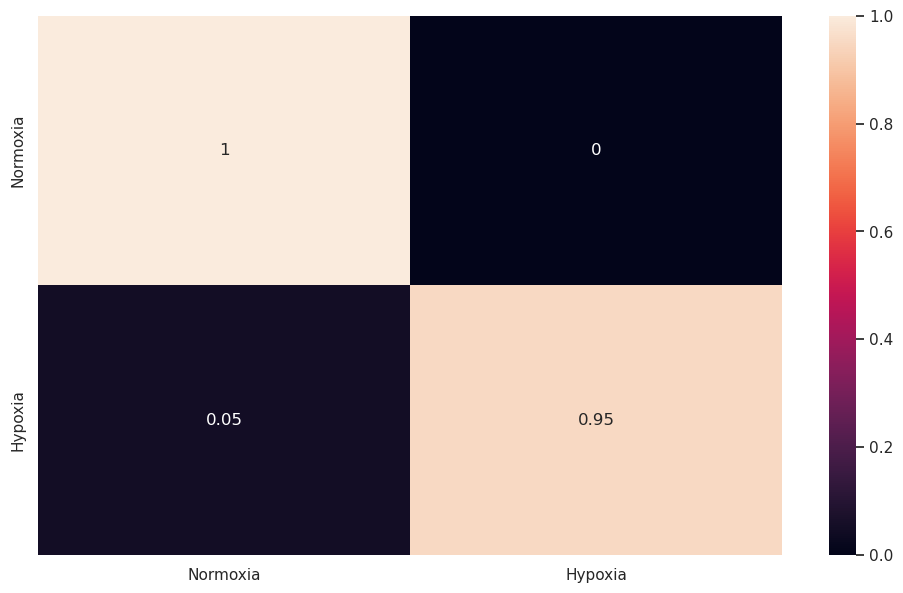

MCF7_DropSeq
F1 Score: 0.9764271513774496
Recall: 0.9700902934537246
Accuracy on test: 98.08136846971799%


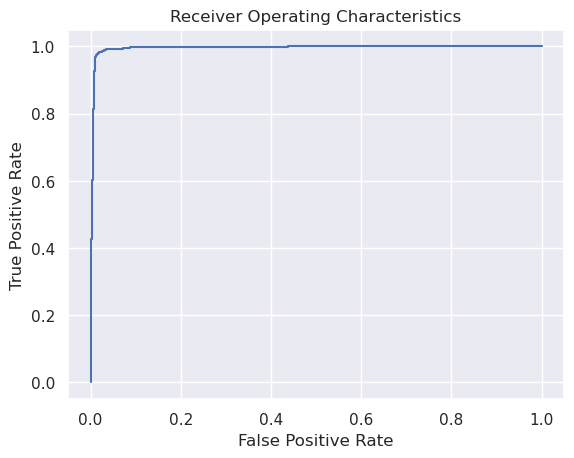

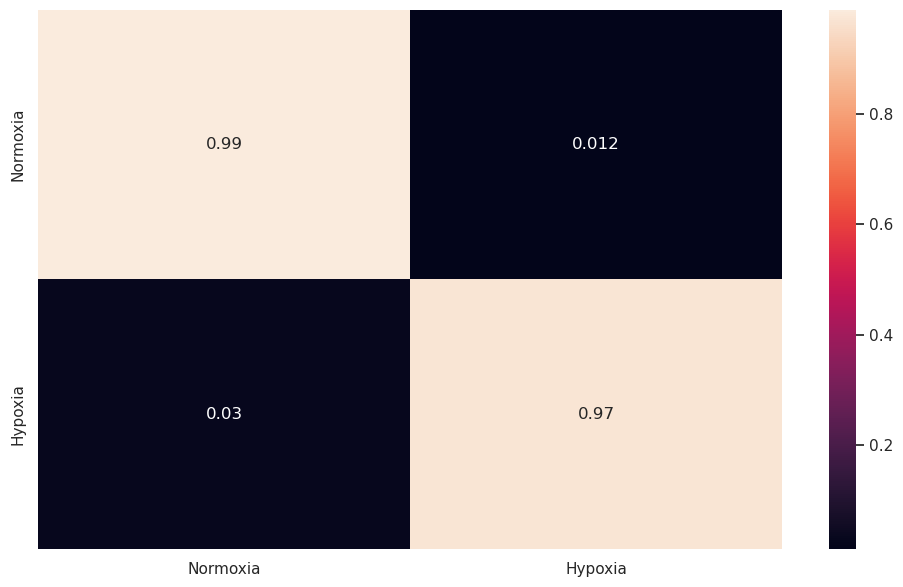

HCC1806_DropSeq
F1 Score: 0.9746764209341587
Recall: 0.9763246899661782
Accuracy on test: 96.93564862104188%


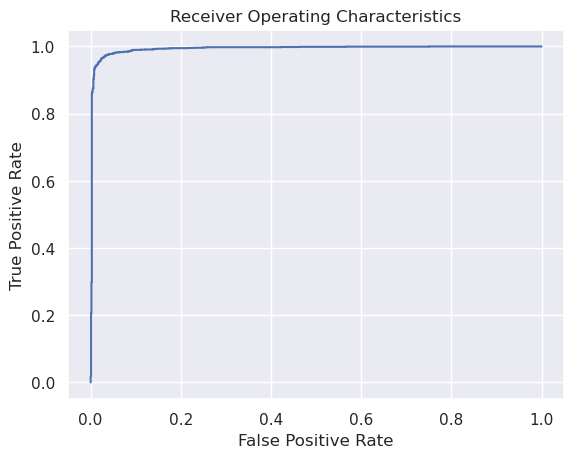

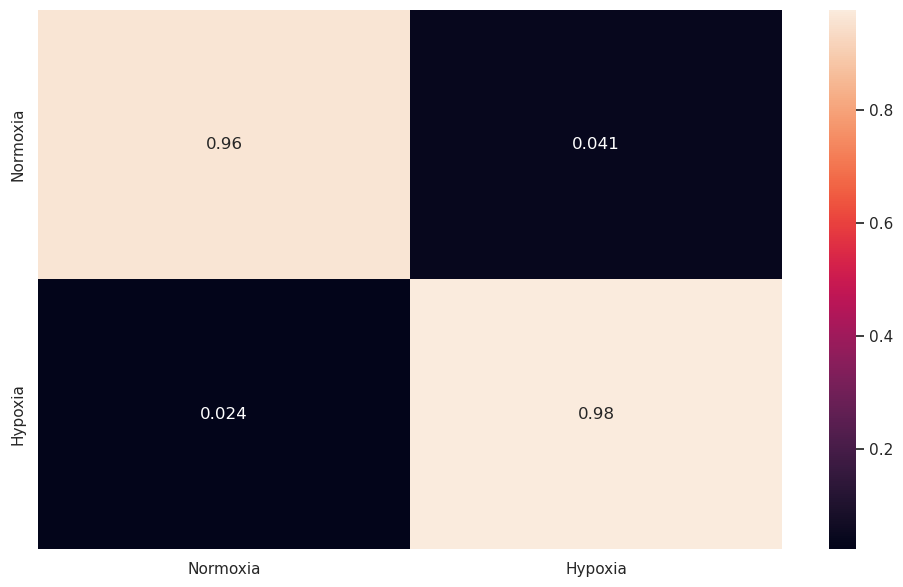

In [48]:
for name, model in models.items():
    print(name)
    measure_model(model, data_loaders_test[name])

In [49]:
for model in models.values():
    model.cpu()
    del model
del models
gc.collect()
torch.cuda.empty_cache()

### Training Over Merged Datasets

In [32]:
input_size = merged_train_dataset.shape[1]

#### Traditional Neural Network

In [81]:
model = NNBig(input_size, 4096, 2048, 1024).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [82]:
train_config = [
    [1, [10, merged_data_loader_train, merged_data_loader_test, ada, bcelogits]]
]

In [85]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.08404361110447296


 10%|█         | 1/10 [00:18<02:43, 18.12s/it]

F1 Score: 0.9661461931739671
Recall: 0.9735449735449735
Accuracy on test: 96.66666666666667%
Epoch 2, Loss: 0.41837044451279165


 20%|██        | 2/10 [00:36<02:24, 18.12s/it]

F1 Score: 0.9660408614025401
Recall: 0.974380395433027
Accuracy on test: 96.6530612244898%
Epoch 3, Loss: 0.3625206127820681


 30%|███       | 3/10 [00:54<02:06, 18.05s/it]

F1 Score: 0.9661754385964912
Recall: 0.9585073795600111
Accuracy on test: 96.72108843537414%
Epoch 4, Loss: 0.012366191210335472


 40%|████      | 4/10 [01:12<01:48, 18.04s/it]

F1 Score: 0.9674650422262218
Recall: 0.9729880256196045
Accuracy on test: 96.80272108843538%
Epoch 5, Loss: 0.026330203750104208


 50%|█████     | 5/10 [01:30<01:30, 18.04s/it]

F1 Score: 0.9687238201619659
Recall: 0.9660261765524923
Accuracy on test: 96.95238095238096%
Epoch 6, Loss: 0.1501021486058011


 60%|██████    | 6/10 [01:48<01:12, 18.04s/it]

F1 Score: 0.9621878052183619
Recall: 0.960178223336118
Accuracy on test: 96.31292517006803%
Epoch 7, Loss: 0.02753622982295253


 70%|███████   | 7/10 [02:06<00:54, 18.07s/it]

F1 Score: 0.9639335023950408
Recall: 0.9526594263436369
Accuracy on test: 96.51700680272108%
Epoch 8, Loss: 0.004766177447925197


 80%|████████  | 8/10 [02:24<00:36, 18.08s/it]

F1 Score: 0.9671857619577308
Recall: 0.9685324422166527
Accuracy on test: 96.78911564625851%
Epoch 9, Loss: 0.003685005538511558


 90%|█████████ | 9/10 [02:42<00:18, 18.05s/it]

F1 Score: 0.963549025148347
Recall: 0.9495962127541074
Accuracy on test: 96.48979591836735%
Epoch 10, Loss: 0.003141266086652673


100%|██████████| 10/10 [03:00<00:00, 18.06s/it]

F1 Score: 0.965033000983008
Recall: 0.9568365357839042
Accuracy on test: 96.61224489795919%


10

F1 Score: 0.9633684210526315
Recall: 0.9557226399331662
Accuracy on test: 96.44897959183673%


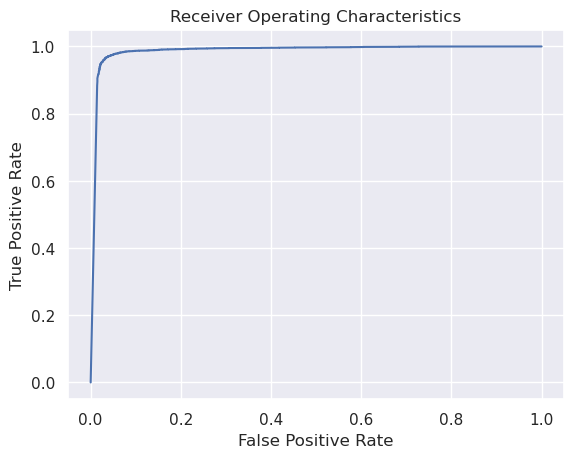

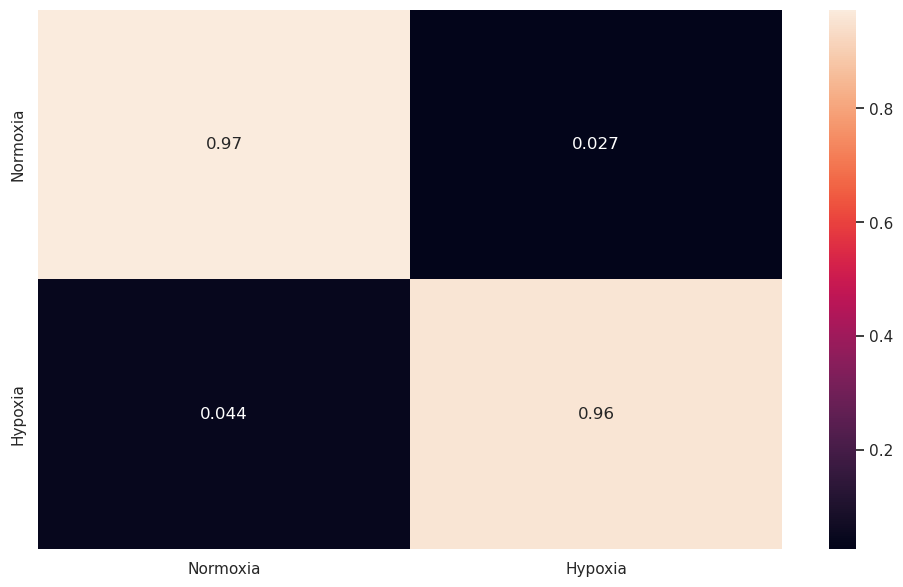

In [86]:
measure_model(model, merged_data_loader_test)

In [77]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

#### KAN (Kolmogorov Arnold Networks)

In [73]:
model = KANTiny(input_size, 512).to(device)
writer = SummaryWriter()
bcelogits = nn.BCEWithLogitsLoss()

lr_ada = 1e-2
ada = optim.Adagrad(model.parameters(), lr=lr_ada)

In [75]:
train_config = [
    [1, [10, merged_data_loader_train, merged_data_loader_test, ada, bcelogits]]
]

In [76]:
train(model, train_config, writer)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 2.9354007379192373


 10%|█         | 1/10 [00:21<03:10, 21.11s/it]

F1 Score: 0.9640148903901834
Recall: 0.9735449735449735
Accuracy on test: 96.44897959183673%
Epoch 2, Loss: 0.0645545287138742


 20%|██        | 2/10 [00:42<02:49, 21.13s/it]

F1 Score: 0.9705516383243468
Recall: 0.9774436090225563
Accuracy on test: 97.10204081632654%
Epoch 3, Loss: 0.038521854674605574


 30%|███       | 3/10 [01:03<02:28, 21.15s/it]

F1 Score: 0.9698160887266601
Recall: 0.961849067112225
Accuracy on test: 97.07482993197279%
Epoch 4, Loss: 0.023463312500034986


 40%|████      | 4/10 [01:24<02:07, 21.17s/it]

F1 Score: 0.9712522787827794
Recall: 0.9643553327763854
Accuracy on test: 97.2108843537415%
Epoch 5, Loss: 0.013734112491669214


 50%|█████     | 5/10 [01:45<01:45, 21.14s/it]

F1 Score: 0.9729880256196045
Recall: 0.9729880256196045
Accuracy on test: 97.36054421768708%
Epoch 6, Loss: 0.00802033881292395


 60%|██████    | 6/10 [02:06<01:24, 21.13s/it]

F1 Score: 0.97265625
Recall: 0.9707602339181286
Accuracy on test: 97.33333333333334%
Epoch 7, Loss: 0.00499498817016897


 70%|███████   | 7/10 [02:28<01:03, 21.18s/it]

F1 Score: 0.9727095516569201
Recall: 0.9727095516569201
Accuracy on test: 97.33333333333334%
Epoch 8, Loss: 0.003217232596564471


 80%|████████  | 8/10 [02:49<00:42, 21.15s/it]

F1 Score: 0.9723849372384937
Recall: 0.9707602339181286
Accuracy on test: 97.3061224489796%
Epoch 9, Loss: 0.0022025807813802005


 90%|█████████ | 9/10 [03:10<00:21, 21.12s/it]

F1 Score: 0.97165991902834
Recall: 0.9690893901420217
Accuracy on test: 97.23809523809524%
Epoch 10, Loss: 0.0015431324953881457


100%|██████████| 10/10 [03:31<00:00, 21.13s/it]

F1 Score: 0.971044901384809
Recall: 0.9665831244778613
Accuracy on test: 97.18367346938776%


10

F1 Score: 0.9674276169265034
Recall: 0.9676970203285993
Accuracy on test: 96.81632653061224%


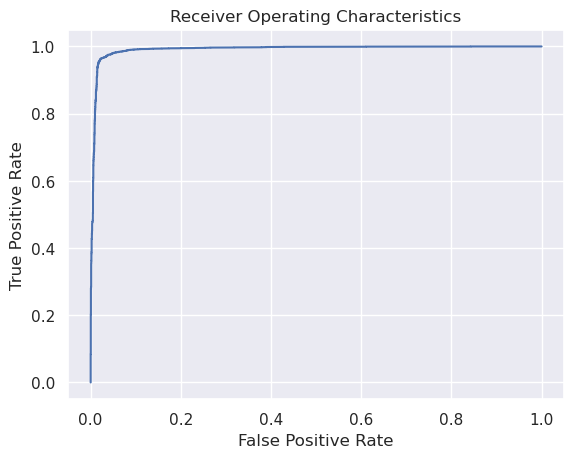

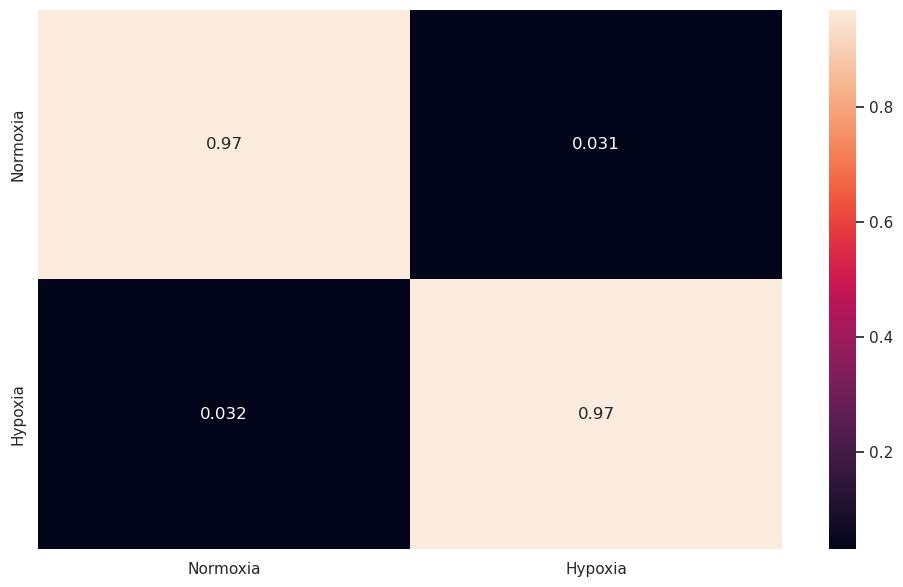

In [65]:
measure_model(model, merged_data_loader_test)

In [ ]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

# TODO: Remove These

In [ ]:
torch.save(model.state_dict(), "KAN_SMART_HCC_Smalljdnf.checkpoint")